# Makemore: Implement the paper MLP

Following [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) and [karpathy Andrej's](https://github.com/karpathy/makemore) repo, we try to implement the model step by step with the following

1. `makemore-practice-part1-paper-mlp`: 
    - Demonstration of how statisitcal models can be transform to scalable nn models. For example, bi-gram to nn from scratch.
2. `makemore-practice-part2-paper-mlp`: 
    - Implement nn from paper. 
    - Introduce basic concepts, for example creating dataset for language models, embedding, tensor indexing, matrix operations, train-test-split, model fitting, mini-batch, stocastic gradient concept, learning weight visualization for model explanation, and prediction. 
3. `makemore-practice-part3-paper-mlp`: 
    - nn initialization diagostic (after linear/non-linear transformation) and tricks to have good init, for example: ideal init loss, avoid over confidence by scaling, and gain. 
    - Introduce batch-morn approach to stablize nn training from scratch
4. `makemore-practice-part4-paper-mlp`: 
    - Reformat the code by mimicing Pytorch. 
    - Then, introduce nn training diagnostic like weight, grad, grad-weight-ratio, grad-weight-std-log-ratio
5. `makemore-practice-part4-paper-mlp`:
    - Everything from scratch

In [1]:
import math
import os
import random
import string

import matplotlib.pyplot as plt
import numpy as np
import torch

from typing import Any
from graphviz import Digraph
from torch.nn import functional as F

os.chdir("/home/project")
%matplotlib inline

In [11]:
prob = torch.tensor([0.9, 0.1])
y = torch.tensor([0., 1.])
print(F.cross_entropy(prob, y))
print((-prob * prob.log()).sum())

tensor(1.1711)
tensor(0.3251)


In [15]:
torch.randint(3, size=(5,), dtype=torch.long)

tensor([0, 1, 0, 2, 0])

In [16]:
batch_size, n_classes = 5, 3
x = torch.randn(batch_size, n_classes)
x.shape

torch.Size([5, 3])

In [17]:
x

tensor([[ 0.3903, -1.3877,  1.0198],
        [ 0.5638, -1.0292,  0.1171],
        [ 1.2834,  1.6599, -1.9301],
        [ 0.4470, -0.0136, -0.2164],
        [ 0.5345, -0.6294, -0.4428]])

In [32]:
def softmax(x):
    return x.exp() / x.exp().sum(1, keepdim=True)


def cross_entropy(x):
    return None

tensor([[0.3283, 0.0555, 0.6162],
        [0.5426, 0.1103, 0.3471],
        [0.4004, 0.5835, 0.0161],
        [0.4660, 0.2940, 0.2400],
        [0.5922, 0.1849, 0.2229]])

In [35]:
pred = x.exp() / x.exp().sum(1, keepdim=True)
target = torch.randint(n_classes, size=(batch_size,), dtype=torch.long)
target

tensor([0, 0, 1, 1, 2])

In [36]:
-pred[torch.arange(pred.shape[0]), target].log().mean()

tensor(0.9979)

In [42]:
log_pred = x.exp().log() - x.exp().sum(1, keepdim=True).log()
-log_pred[torch.arange(pred.shape[0]), target].mean()

tensor(0.9979)

In [43]:
F.cross_entropy(x, target)

tensor(0.9979)

## 1. Make the process more like Pytorch 

**1.1 Model global settings**

In [2]:
size = 3
v_size = 27
n_embed = 8
n_hidden = 256
g = torch.Generator().manual_seed(2147483647)

In [ ]:
def soft_max():
    return 

**1.2 Read and Prepare Data**

In [3]:
def read_txt(nrows: int = None):
    words = []
    with open("practice/makemore/name.txt", "r") as f:
        if nrows:
            for _ in range(nrows):
                words.append(f.readline().splitlines()[0])
        else:
            for line in f:
                words.append(line.splitlines()[0])
    return words


def get_lookup_map():
    lowercases = string.ascii_lowercase
    stoi = {s: i for i, s in enumerate(lowercases, start=1)}
    stoi["."] = 0
    itos = {val: key for key, val in stoi.items()}
    return stoi, itos


def preprocess(words: list, stoi: dict, size: int = 3):
    x, y = [], []
    for word in words:
        context = [0] * size
        for s in word + ".":
            idx = stoi[s]
            x.append(context)
            y.append(idx)
            context = context[1:] + [idx]
    x = torch.tensor(x)
    y = torch.tensor(y)
    print(x.shape, y.shape)
    return (x, y)


def train_eval_test_split(X: torch.tensor, Y: torch.tensor) -> torch.tensor:
    train_cnt = int(X.shape[0] * 0.8)
    test_cnt = int(X.shape[0] * 0.9)
    idx = torch.randperm(train_cnt)
    x_train, y_train = X[idx], Y[idx]
    x_eval, y_eval = X[train_cnt:test_cnt], Y[train_cnt:test_cnt]
    x_test, y_test = X[test_cnt:], Y[test_cnt:]
    return x_train, y_train, x_eval, y_eval, x_test, y_test


words = read_txt(None)
stoi, itos = get_lookup_map()
X, Y = preprocess(words=words[:], stoi=stoi, size=size)
x_train, y_train, x_eval, y_eval, x_test, y_test = train_eval_test_split(X, Y)
print(f"Rows: {len(words)}")
print(f"Top 5 rows: {words[:5]}")
print(stoi)
print(itos)
print(x_train[:5])
print(y_train[:5])
print(x_eval[:5])
print(y_eval[:5])

torch.Size([228146, 3]) torch.Size([228146])
Rows: 32033
Top 5 rows: ['emma', 'olivia', 'ava', 'isabella', 'sophia']
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
tensor([[18,  9, 19],
        [ 0,  3,  1],
        [ 4, 26,  9],
        [15, 12,  9],
        [21, 18,  5]])
tensor([20, 13,  1, 22, 13])
tensor([[ 0,  0, 26],
        [ 0, 26, 21],
        [26, 21,  8],
        [21,  8,  1],
        [ 8,  1,  9]])
tensor([21,  8,  1,  9,  2])


**1.3 Building the Blocks**

In [5]:
class Linear:
    def __init__(self, in_features: int, out_features: int, bias: bool) -> None:
        self.w = torch.randn(in_features, out_features, generator=g) / in_features ** 0.5
        self.b = torch.randn(1, out_features, generator=g) if bias else None

    def __call__(self, x) -> torch.tensor:
        self.out = x @ self.w
        if self.b is not None:
            self.out += self.b
        return self.out

    def parameters(self) -> list[torch.tensor]:
        return [self.w, self.b] if self.b is not None else [self.w]


class BatchNorm1d:
    def __init__(
        self, num_features: int, eps: float = 1e-5, momentum: float = 0.1
    ) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.b_mean = torch.zeros(num_features)
        self.b_var = torch.ones(num_features)
        self.gamma = torch.ones(num_features)
        self.beta = torch.zeros(num_features)

    def __call__(self, x) -> torch.tensor:
        if self.training:
            x_b_mean = x.mean(0, keepdim=True)
            x_b_var = x.var(0, keepdim=True)
        else:
            x_b_mean = self.b_mean
            x_b_var = self.b_var
        self.out = self.gamma * (x - x_b_mean) / (x_b_var + self.eps) ** 0.5 + self.beta
        if self.training:
            with torch.no_grad():
                self.b_mean = (
                    1 - self.momentum
                ) * self.b_mean + self.momentum * self.eps
                self.b_var = (1 - self.momentum) * self.b_var + self.momentum * self.eps
        return self.out

    def parameters(self) -> list[torch.tensor]:
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

**1.4 See the unstability before batch-norm**

In [24]:
C = torch.randn((v_size, n_embed), generator=g)
layers = [
    Linear(size * n_embed, n_hidden, bias=False),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    Tanh(),
    Linear(n_hidden, v_size, bias=False)
]

with torch.no_grad():
    # last layer: make less confident -> less loss -> less unnecessary training
    layers[-1].w *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            # play with the numbers to see how unstable it is
            layer.w *= 1  # gain of (5 / 3) is bettern

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

275416


In [28]:
loss_train, steps, ud = [], [], []
batch_size = 32
iterations = 200000


def train(
    iterations: int,
    mini_batch: int = 32,
    momentum: float = 0.001,
    eps: float = 10**-5,
):
    for i in range(iterations):
        ix = torch.randint(0, x_train.shape[0], size=(mini_batch,), generator=g)
        x_train_batch, y_train_batch = x_train[ix], y_train[ix]
        embedding = C[x_train_batch]
        x = embedding.view(x_train_batch.shape[0], -1)
        for layer in layers:
            x = layer(x)
        loss = F.cross_entropy(x, y_train_batch)

        for layer in layers:
            layer.out.retain_grad()
        for p in parameters:
            p.grad = None
        loss.backward()

        lr = 0.1 if i < 150000 else 0.01
        for p in parameters:
            p.data -= lr * p.grad

        loss_train.append(loss.log10().item())
        steps.append(i)

        if i % 10000 == 0:
            print(f"iteration: {i:7d} /{iterations:7d}, train loss: {loss.item():.4f}")
        loss_train.append(loss.log10().item())
        with torch.no_grad():
            ud.append(
                [
                    ((lr * p.grad).std() / p.data.std()).log10().item()
                    for p in parameters
                ]
            )
        # this is more for grad/data ratio plt, learing plot
        if i == 10000:
            break
        # this is more for weight plot, grad plot, grad/data ratio plt
        # if i == 0:
        #     break

    print(f"train loss: {loss}")
    return loss_train, steps


loss_train, steps = train(iterations=iterations, mini_batch=batch_size)

iteration:       0 / 200000, train loss: 3.2719
iteration:   10000 / 200000, train loss: 2.4466
train loss: 2.4466235637664795


layer 1 (      Tanh): mean +0.01, std 0.59, saturated: 2.05%
layer 3 (      Tanh): mean -0.01, std 0.47, saturated: 0.05%
layer 5 (      Tanh): mean +0.00, std 0.40, saturated: 0.00%
layer 7 (      Tanh): mean -0.00, std 0.35, saturated: 0.00%
layer 9 (      Tanh): mean +0.01, std 0.31, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

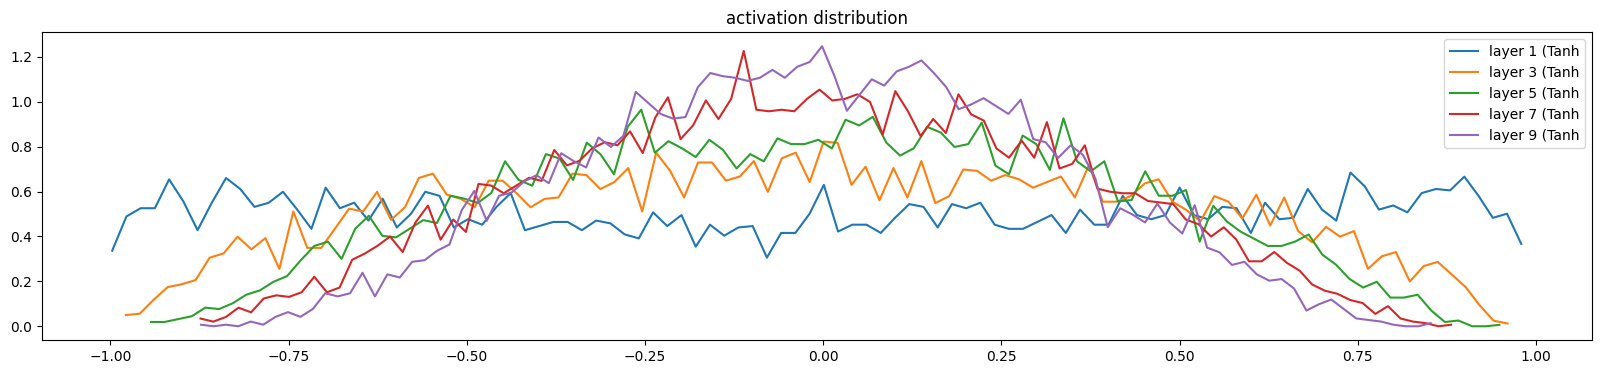

In [26]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean -0.000001, std 2.476862e-04
layer 3 (      Tanh): mean -0.000009, std 2.453593e-04
layer 5 (      Tanh): mean +0.000000, std 2.309273e-04
layer 7 (      Tanh): mean +0.000002, std 2.098888e-04
layer 9 (      Tanh): mean +0.000002, std 1.902730e-04


Text(0.5, 1.0, 'gradient distribution')

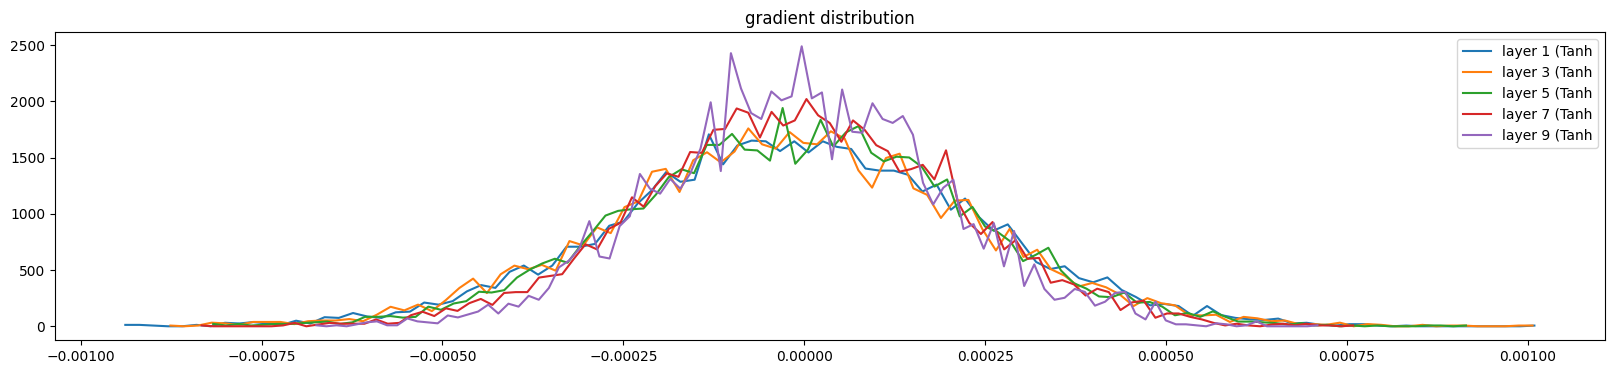

In [9]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight    (27, 8) | mean -0.000009 | std 4.439498e-04 | grad:data ratio 4.507531e-04
weight  (24, 256) | mean +0.000004 | std 4.060908e-04 | grad:data ratio 2.000920e-03
weight (256, 256) | mean -0.000001 | std 3.825720e-04 | grad:data ratio 6.117598e-03
weight (256, 256) | mean +0.000001 | std 3.752749e-04 | grad:data ratio 5.999922e-03
weight (256, 256) | mean +0.000000 | std 3.766150e-04 | grad:data ratio 6.004148e-03
weight (256, 256) | mean -0.000000 | std 3.857916e-04 | grad:data ratio 6.170186e-03
weight  (256, 27) | mean +0.000000 | std 1.143919e-02 | grad:data ratio 1.797022e+00


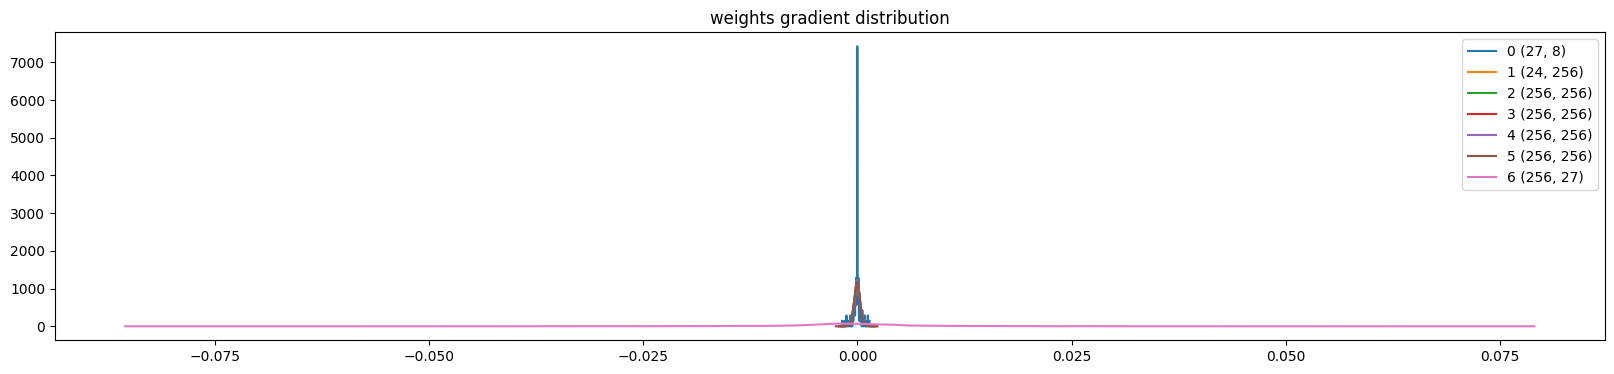

In [27]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

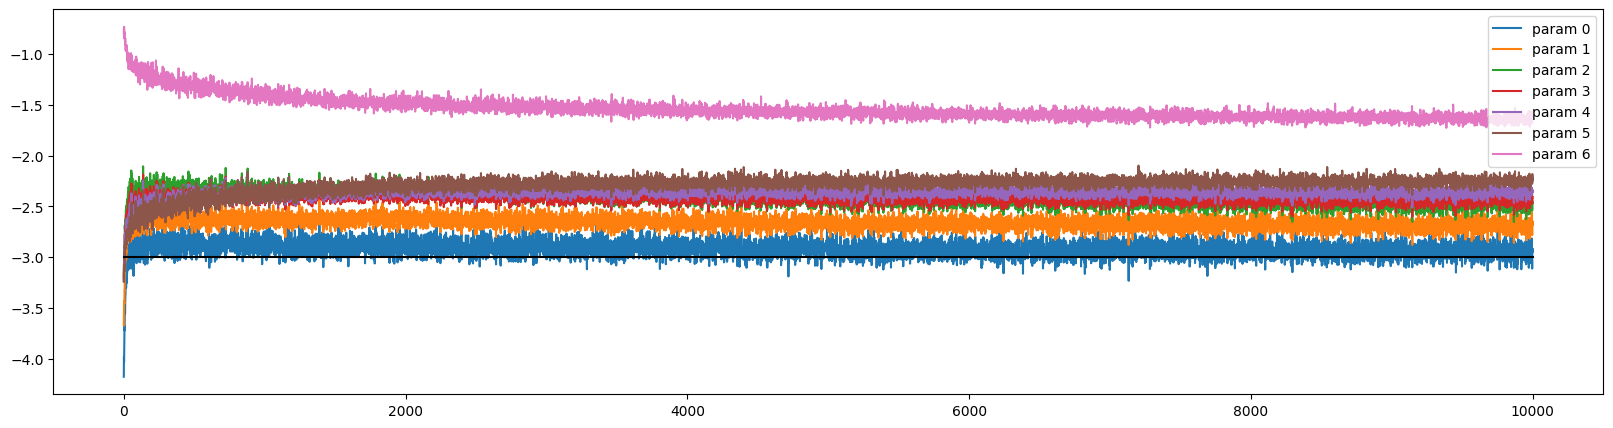

In [29]:
plt.figure(figsize=(20, 5))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


**1.5 See the unstability after batch-norm**

In [34]:
C = torch.randn((v_size, n_embed), generator=g)
layers = [
    Linear(size * n_embed, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, v_size, bias=False),
    BatchNorm1d(v_size),
]

with torch.no_grad():
    # last layer: make less confident -> less loss -> less unnecessary training
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            # after batch-norm, only the learning rate is more affected by gain setting
            layer.w *= 1  # (5 / 3)

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

278030


In [39]:
loss_train, steps, ud = [], [], []
batch_size = 32
iterations = 200000


def train(
    iterations: int,
    mini_batch: int = 32,
    momentum: float = 0.001,
    eps: float = 10**-5,
):
    for i in range(iterations):
        ix = torch.randint(0, x_train.shape[0], size=(mini_batch,), generator=g)
        x_train_batch, y_train_batch = x_train[ix], y_train[ix]
        embedding = C[x_train_batch]
        x = embedding.view(x_train_batch.shape[0], -1)
        for layer in layers:
            x = layer(x)
        loss = F.cross_entropy(x, y_train_batch)

        for layer in layers:
            layer.out.retain_grad()
        for p in parameters:
            p.grad = None
        loss.backward()

        lr = 0.1 if i < 150000 else 0.01
        for p in parameters:
            p.data -= lr * p.grad

        loss_train.append(loss.log10().item())
        steps.append(i)

        if i % 10000 == 0:
            print(f"iteration: {i:7d} /{iterations:7d}, train loss: {loss.item():.4f}")
        loss_train.append(loss.log10().item())
        with torch.no_grad():
            ud.append(
                [
                    ((lr * p.grad).std() / p.data.std()).log10().item()
                    for p in parameters
                ]
            )
        # this is more for grad/data ratio plt, learing plot
        if i == 10000:
            break
        # this is more for weight plot, grad plot, grad/data ratio plt
        # if i == 0:
        #     break

    print(f"train loss: {loss}")
    return loss_train, steps


loss_train, steps = train(iterations=iterations, mini_batch=batch_size)

iteration:       0 / 200000, train loss: 3.3088
iteration:   10000 / 200000, train loss: 2.3834
train loss: 2.383401870727539


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 3.41%
layer 5 (      Tanh): mean +0.00, std 0.63, saturated: 2.95%
layer 8 (      Tanh): mean +0.00, std 0.64, saturated: 2.73%
layer 11 (      Tanh): mean +0.00, std 0.64, saturated: 2.75%
layer 14 (      Tanh): mean -0.00, std 0.63, saturated: 3.14%


Text(0.5, 1.0, 'activation distribution')

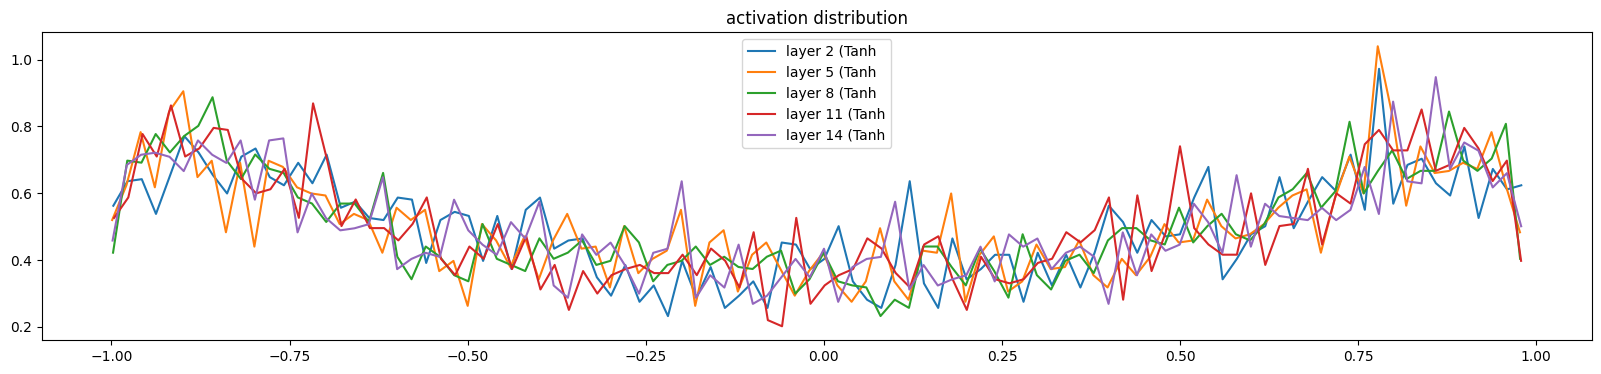

In [36]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 6.298990e-04
layer 5 (      Tanh): mean -0.000000, std 5.023402e-04
layer 8 (      Tanh): mean -0.000000, std 4.222171e-04
layer 11 (      Tanh): mean -0.000000, std 3.756841e-04
layer 14 (      Tanh): mean -0.000000, std 3.266063e-04


Text(0.5, 1.0, 'gradient distribution')

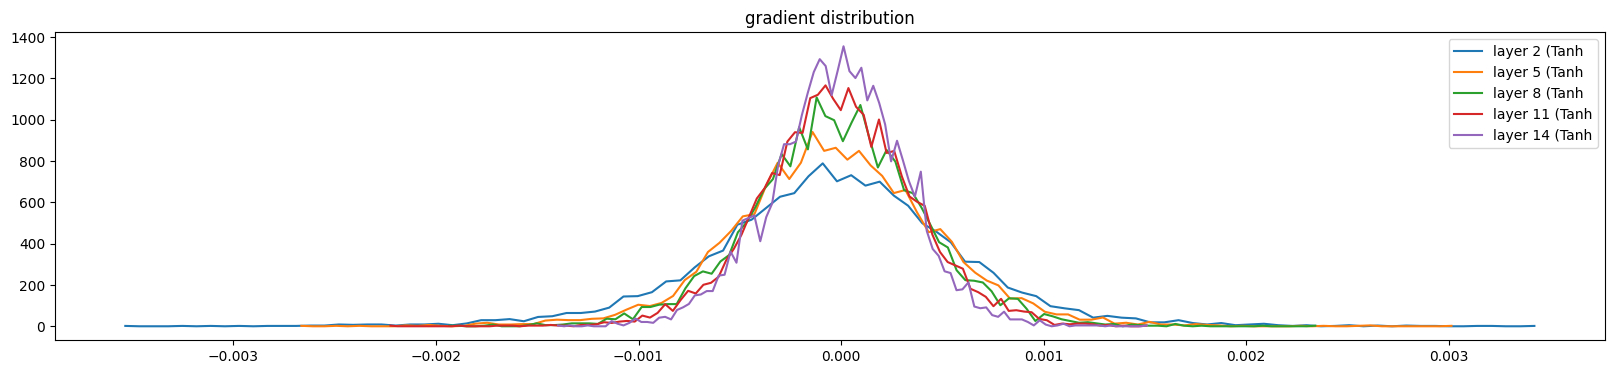

In [38]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight    (27, 8) | mean -0.000000 | std 1.994626e-03 | grad:data ratio 2.021678e-03
weight  (24, 256) | mean +0.000000 | std 2.353127e-03 | grad:data ratio 1.153183e-02
weight (256, 256) | mean -0.000011 | std 1.967623e-03 | grad:data ratio 3.155953e-02
weight (256, 256) | mean -0.000012 | std 1.671260e-03 | grad:data ratio 2.670149e-02
weight (256, 256) | mean +0.000005 | std 1.496179e-03 | grad:data ratio 2.391920e-02
weight (256, 256) | mean +0.000003 | std 1.359120e-03 | grad:data ratio 2.174254e-02
weight  (256, 27) | mean +0.000011 | std 3.497325e-03 | grad:data ratio 5.540015e-02


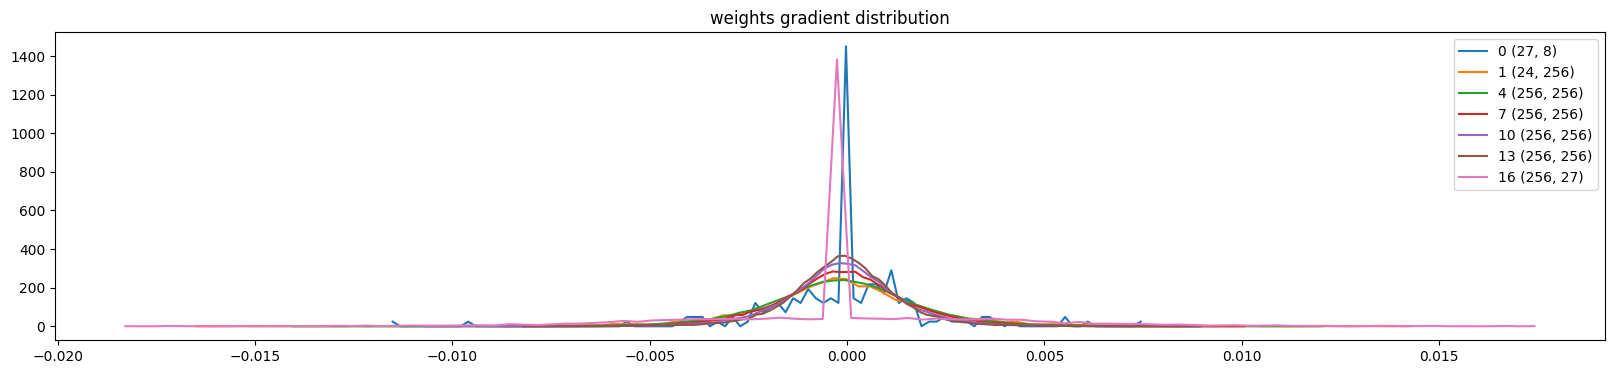

In [37]:
# visualize histograms
# this plot will be betterb after several iterations!!
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

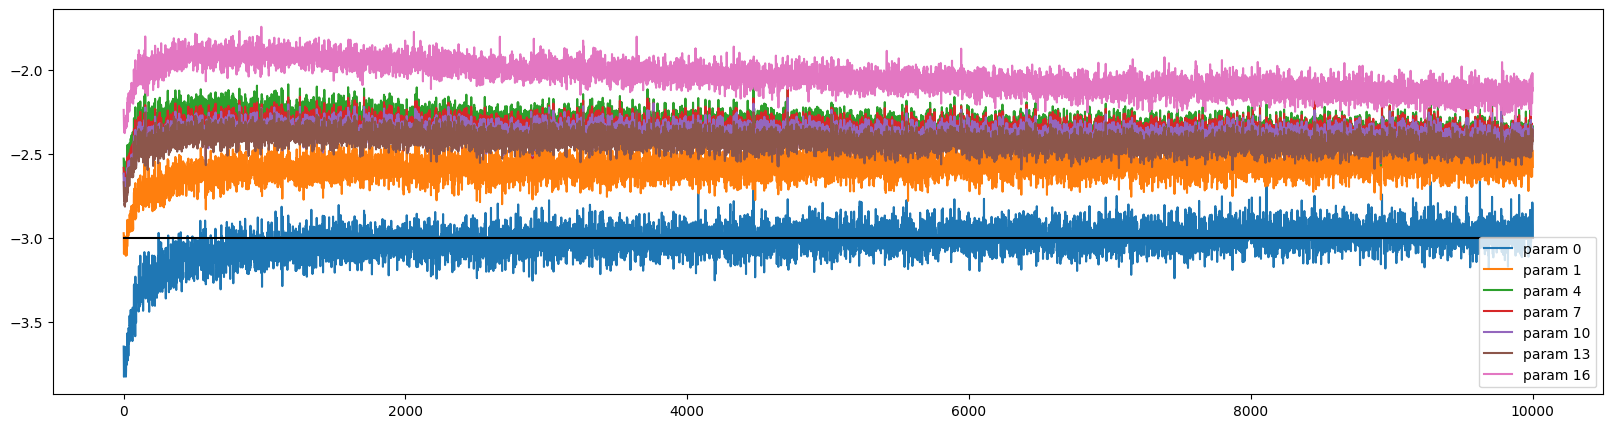

In [40]:
plt.figure(figsize=(20, 5))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);